In [41]:
%load_ext autoreload
%autoreload 2
import os
import shutil
if not os.path.exists('configs'): get_ipython().run_line_magic('cd', '..')

from utils import plot_utils as putils
custom_color_dict = putils.set_matplotlib_params()

from preprocessing.preprocessing_utils import Backup, get_data_paths, get_figure_path
asset_path, data_path = get_data_paths('./configs')
figure_path = get_figure_path('./configs')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [42]:
# Standard library imports
from pathlib import Path
from datetime import datetime
import json
import pickle
from collections import defaultdict

# Data handling and preprocessing
import pandas as pd
import numpy as np

# Geospatial data handling
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopandas as gpd

# Visualization
import matplotlib.pyplot as plt

# Parallel processing
from multiprocessing import Pool

import matplotlib as mpl
import matplotlib.ticker as ticker
from matplotlib import cm

In [43]:
train_data = pd.read_csv((Path(asset_path, '01_electric_train_features.csv')))
test_data  = pd.read_csv((Path(asset_path, '01_electric_test_features.csv')))

train_data['datetime'] = pd.to_datetime(train_data['datetime'])
test_data['datetime'] = pd.to_datetime(test_data['datetime'])

pre_num_train      = train_data['num'].values
pre_datetime_train = train_data['datetime'].values

pre_num_test      = test_data['num'].values
pre_datetime_test = test_data['datetime'].values

In [44]:
train_data.columns

Index(['is_dummy', 'num', 'lat', 'lon', 'district', 'units', 'year',
       'datetime', 'holiday', 'altitude', 'temp', 'humid', 'wind', 'rain',
       'tchi', 'dci', 'hi', 'wchi', 'atemp', 'sum_qctr', 'sum_load',
       'avg_load', 'n_mean_load', 'elec'],
      dtype='object')

In [45]:
not_dummy_idx_train = train_data['is_dummy'] == 0
not_dummy_idx_test  = test_data['is_dummy']  == 0

In [46]:
get_backup = False
Backup.save_with_key(train_data, f'backup1_train')
Backup.save_with_key(test_data, f'backup1_test')
if get_backup:
    train_data = Backup.copy_data_with_key(f'backup1_train')
    test_data  = Backup.copy_data_with_key(f'backup1_test')

Data Key "fbackup1_train" already exists, Skip Saving
Data Key "fbackup1_test" already exists, Skip Saving


In [47]:
train_data['month'] = train_data['datetime'].dt.month
train_data['hour'] = train_data['datetime'].dt.hour

___

In [9]:
train_elec_total = train_data['elec'][not_dummy_idx_train].values

In [48]:
year_info_dict = {}

for year1 in [2020, 2021, 2022]:
    num_grouped = train_data[train_data['year'] == year1][['num', 'units', 'datetime', 'elec', 'sum_load','is_dummy']].groupby('num')
    elec_dict_num = {}
    sum_load_dict_num = {}
    num_to_units = {}
    for num, group in num_grouped:
        elec_dict_num[num] = group[group['is_dummy']==0]['elec'].values
        sum_load_dict_num[num] = group[group['is_dummy']==0]['sum_load'].values
        num_to_units[num] = group[group['is_dummy']==0]['units'].values[0]

    year_info_dict[year1] = {'elec': elec_dict_num, 'sum_load': sum_load_dict_num, 'units': num_to_units, 'datetime': group[group['is_dummy']==0]['datetime'].values}

____

### 전력기상지수 분포 그리기

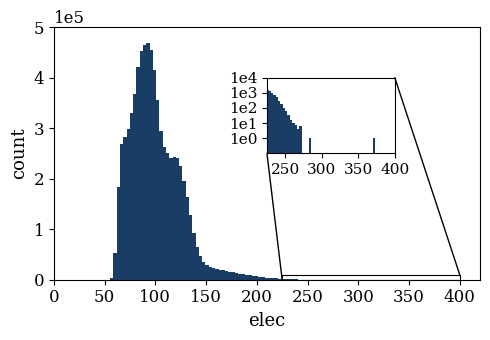

In [12]:
fig = plt.figure(figsize=(5, 3.5))
ax = fig.gca()

fsize1 = 15
fsize2 = 13
fsize3 = 12
fsize4 = 11

my_navy = custom_color_dict['custom_navy']

ax.hist(train_elec_total, bins=100, color=my_navy)
# set y axis log scale
#ax.set_yscale('log')

# ax.set_title('elec distribution of train data', fontsize=fsize1)
ax.set_xlabel('elec', fontsize=fsize2)
ax.set_ylabel('count', fontsize=fsize2)
#ax.legend()
ax.set_xlim(0, 420)
ax.set_xticks([0, 50, 100, 150, 200, 250, 300, 350, 400])

ax.set_ylim(0, 500000)
ax.set_yticks([0, 100000, 200000, 300000, 400000, 500000])
# format as scientific notation
ax.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
# set exponent fontsize
ax.yaxis.get_offset_text().set_fontsize(fsize3)
# fontsize
ax.tick_params(axis='both', which='major', labelsize=fsize3)

axins = ax.inset_axes([0.5, 0.5, 0.3, 0.3], xlim=(225, 400), ylim=(0, 10000), xticklabels=[], yticklabels=[])
edgecolor = 'black'
for spine in axins.spines.values():
    spine.set_edgecolor(edgecolor)
    spine.set_linewidth(0.8 if edgecolor == 'black' else 2.0)
indicate = ax.indicate_inset_zoom(axins, edgecolor="black", zorder=110)
indicate[0].set_linewidth(0.8)
indicate[0].set_edgecolor('black')
indicate[0].set_alpha(1.0)
indicate[0].set_linestyle('-')
for line in indicate[1]:
    line.set_linewidth(1.0)
    line.set_color('black')
    line.set_alpha(1.0)

axins.set_yscale('log')
axins.hist(train_elec_total, bins=100, color=my_navy)
axins.set_ylim(0.1, 10000)
axins.set_xticks([250, 300, 350, 400])
axins.set_yticks([1, 10, 100, 1000, 10000])
axins.set_xticklabels([250, 300, 350, 400], fontsize=fsize4)
axins.set_yticklabels([f'1e{i}' for i in [0,1,2,3,4]], fontsize=fsize4)
# format yticklabel as scientific notation
# y축을 과학적 표기법으로 설정 (로그 축의 경우)
#axins.yaxis.set_major_formatter(ticker.LogFormatterSciNotation())

fig.tight_layout()
fig.savefig(Path(figure_path, 'elec_distribution.png'), dpi=600)
plt.show()

____

### 분포 자세히 분석

In [50]:
train_elec_values = train_elec_total # np.log10(train_elec_total)  #
train_log_elec_values = np.log10(train_elec_total)

def standardize(x):
    return (x - np.mean(x)) / np.std(x)

def skewness(x):
    return np.mean((x - np.mean(x))**3) / np.std(x)**3

elec_Z = standardize(train_elec_values)
elec_log_Z = standardize(train_log_elec_values)

elec_skew = skewness(train_elec_values)
elec_log_skew = skewness(train_log_elec_values)

print(f'elec skewness: {elec_skew:.4f}')
print(f'elec log skewness: {elec_log_skew:.4f}')

elec skewness: 1.1661
elec log skewness: 0.3770


<Figure size 500x350 with 0 Axes>

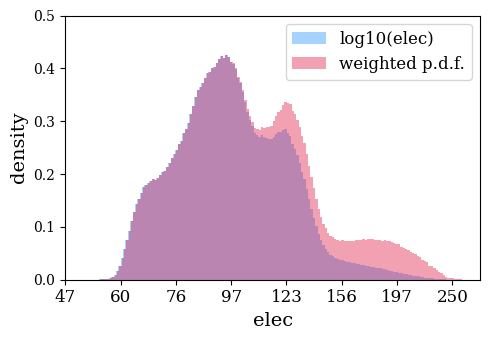

In [77]:
fig = plt.figure(figsize=(5, 3.5))

fsize1 = 15
fsize2 = 14
fsize3 = 12
fsize4 = 9

# 가중치 함수 정의
slope = 0.35
def weight_function(y):
    return np.exp(0.5 * slope * np.square(np.maximum(0, y)))

fig = plt.figure(figsize=(5, 3.5))
ax = fig.gca()

# 원래 히스토그램
hist, bins, _ = ax.hist(elec_log_Z, bins=200, color='dodgerblue', density=True, alpha=0.4, label='log10(elec)')

# PDF 계산 및 가중치 적용
bin_centers = 0.5 * (bins[1:] + bins[:-1])
weighted_pdf = hist * weight_function(bin_centers)

# 가중치 적용된 히스토그램 그리기
ax.hist(bin_centers, bins=200, weights=weighted_pdf, color='crimson', alpha=0.4, label='weighted p.d.f.')

ax.set_xlim(-3, 4.5)
ax.set_ylim(0, 0.5)
#ax.set_yscale('log')
ax.set_xlabel('elec', fontsize=fsize2)
ax.set_ylabel('density', fontsize=fsize2)

mean_log_elec = np.mean(train_log_elec_values)
std_log_elec = np.std(train_log_elec_values)
# set tick as real value
ax.set_xticks([-3, -2, -1, 0, 1, 2, 3, 4])
# set tick as real value
ax.set_xticklabels( [ f'{int(np.power(10,i * std_log_elec + mean_log_elec)):d}' for i in [-3, -2, -1, 0, 1, 2, 3, 4]], fontsize=fsize3)

ax.legend(fontsize=fsize3)

fig.tight_layout()

fig.savefig(Path(figure_path, 'weighted_pdf.png'), dpi=600)

Skewness of Gaussian: 0.2116


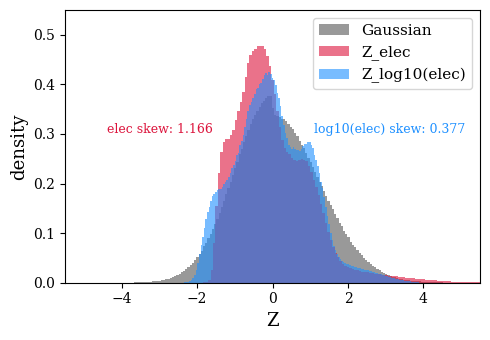

In [52]:
fig = plt.figure(figsize=(5, 3.5))

fsize1 = 15
fsize2 = 13
fsize3 = 11
fsize4 = 9

ax = fig.gca()
gaussian_Z_1 = np.random.randn(len(elec_Z))
gaussian_Z_2 = np.random.randn(int(len(elec_Z)*np.power(1.24,0.5))) * 1.24
gaussian_Z = np.concatenate([gaussian_Z_1[gaussian_Z_1<=0], gaussian_Z_2[gaussian_Z_2>=0]])
print(f'Skewness of Gaussian: {skewness(gaussian_Z):.4f}')

ax.hist(gaussian_Z, bins=200, color='black', density=True, alpha=0.4, label='Gaussian')
ax.hist(elec_Z, bins=200, color='crimson', density=True, alpha=0.6, label='Z_elec')
ax.hist(elec_log_Z, bins=200, color='dodgerblue', density=True, alpha=0.6, label='Z_log10(elec)')
ax.set_xlim(-5.5, 5.5)
ax.set_ylim(0, 0.55)
#ax.set_yscale('log')

ax.set_xlabel('Z', fontsize=fsize2)
ax.set_ylabel('density', fontsize=fsize2)
ax.legend(fontsize=fsize3)

# annotate skewness
ax.annotate(f'elec skew: {elec_skew:.3f}', xy=(0.10, 0.55), xycoords='axes fraction', fontsize=fsize4, color='crimson')
ax.annotate(f'log10(elec) skew: {elec_log_skew:.3f}', xy=(0.60, 0.55), xycoords='axes fraction', fontsize=fsize4, color='dodgerblue')

fig.tight_layout()
fig.savefig(Path(figure_path, 'skewness.png'), dpi=600)

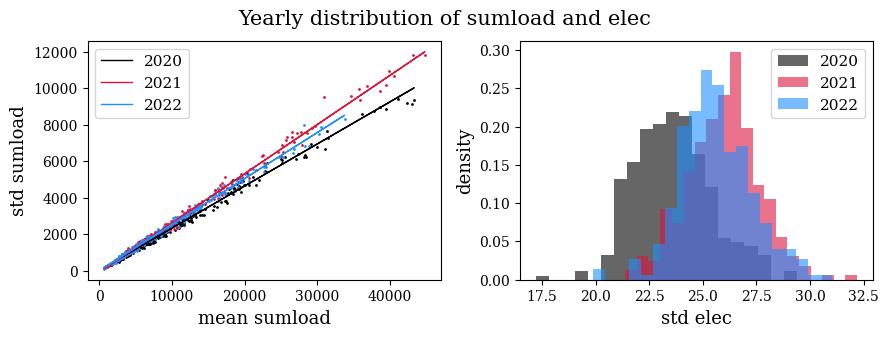

In [85]:
colors = ['black', 'crimson', 'dodgerblue']

fsize1 = 15
fsize2 = 13
fsize3 = 11
fsize4 = 11

fig, axs = plt.subplots(1,2,figsize=(9, 3.5))

for year1 in [2020, 2021, 2022]:
    color = colors[year1-2020]
    elec_dict_num = year_info_dict[year1]['elec']
    sum_load_dict_num = year_info_dict[year1]['sum_load']

    dict_nums = list(elec_dict_num.keys())
    dict_nums.sort()
    elec_std_list = []
    logelec_std_list = []
    sum_load_mean_list = []
    sum_load_std_list = []

    for num in dict_nums:
        elec_std_list.append(np.std(elec_dict_num[num]))
        logelec_std_list.append(np.std(np.log10(elec_dict_num[num])))
        sum_load_mean_list.append(np.mean(sum_load_dict_num[num]))
        sum_load_std_list.append(np.std(sum_load_dict_num[num]))

    axs[0].scatter(sum_load_mean_list, sum_load_std_list, s=1, c = color)
    # add linear regression line
    x = np.array(sum_load_mean_list)
    y = np.array(sum_load_std_list)
    m, b = np.polyfit(x, y, 1)
    axs[0].plot(x, m*x + b, linewidth=1.0, c = color, label = f'{year1}')

    axs[1].hist(elec_std_list, bins=20, color=color, alpha=0.6, label=f'{year1}',density=True)

axs[0].legend(fontsize=fsize3)
axs[0].set_xlabel('mean sumload', fontsize=fsize2)
axs[0].set_ylabel('std sumload', fontsize=fsize2)

axs[1].legend(fontsize=fsize3)
axs[1].set_xlabel('std elec', fontsize=fsize2)
axs[1].set_ylabel('density', fontsize=fsize2)

fig.suptitle('Yearly distribution of sumload and elec', fontsize=fsize1, y=0.95)
fig.tight_layout()
fig.savefig(Path(figure_path, 'yearly_distribution.png'), dpi=600)

______

### 계절, 지역 구분 별 Elec

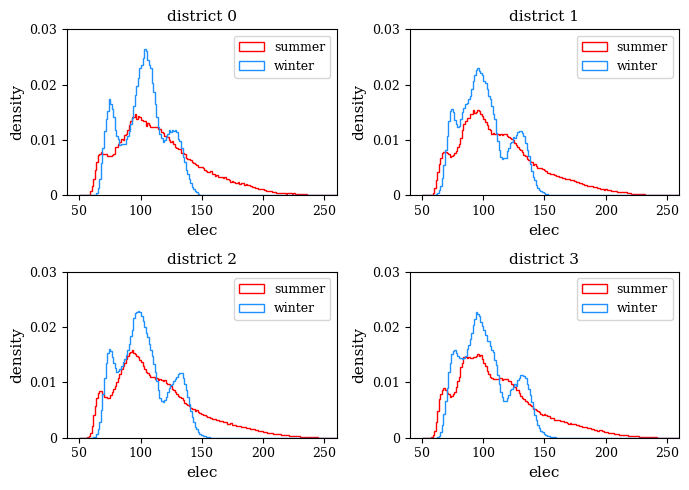

In [66]:
fig, axs = plt.subplots(2, 2, figsize=(7, 5))

fsize1 = 15
fsize2 = 11
fsize3 = 9
fsize4 = 11

district = [0,1,2,3]
facecolors = ['darkorange', 'crimson', 'indigo', 'dodgerblue']

spring_mask = train_data['month'].isin([3,4,5])
summer_mask = train_data['month'].isin([6,7,8])
fall_mask = train_data['month'].isin([9,10,11])
winter_mask = train_data['month'].isin([12,1,2])

bin_list = np.linspace(50, 300, 200)
lw = 1.0
for i in district:
    ax = axs[i//2, i%2]
    ax.set_title(f'district {i}', fontsize=fsize2)
    ax.hist(train_data['elec'][not_dummy_idx_train & (train_data['district'] == i) & summer_mask].values, 
                        bins=bin_list, color='red', label=f'summer', density=True, zorder=1,
                        histtype='step', linewidth=lw)
    ax.hist(train_data['elec'][not_dummy_idx_train & (train_data['district'] == i) & winter_mask].values,
                        bins=bin_list, color='dodgerblue', label=f'winter', density=True, zorder=1,
                        histtype='step', linewidth=lw)
    ax.set_xlabel('elec', fontsize=fsize2)
    ax.set_ylabel('density', fontsize=fsize2)
    ax.set_xlim(40, 260)
    ax.set_xticks([50, 100, 150, 200, 250])
    ax.set_xticklabels([50, 100, 150, 200, 250], fontsize=fsize3)
    ax.set_ylim(0, 0.03)
    ax.set_yticks([0, 0.01, 0.02, 0.03])
    ax.set_yticklabels([0, 0.01, 0.02, 0.03], fontsize=fsize3)
    ax.legend(fontsize=fsize3)

fig.tight_layout()
fig.savefig(Path(figure_path, 'elec_by_season.png'), dpi=600)

____

In [112]:
import scipy.stats as stats

units_list = []
elec_stats_list = []

for val_year in [2020, 2021, 2022]:

    elec_dict_num = year_info_dict[val_year]['elec']
    sum_load_dict_num = year_info_dict[val_year]['sum_load']
    num_to_units = year_info_dict[val_year]['units']

    dict_nums = list(elec_dict_num.keys())

    for num in dict_nums:
        units_list.append(num_to_units[num])

        elec_vals  = elec_dict_num[num]
        #iqr = np.percentile(elec_vals, 75) - np.percentile(elec_vals, 25)
        elec_stats = np.median(elec_vals)
        elec_stats_list.append(elec_stats)

R2: 0.1687
Lagrange multiplier statistic: 0.27384966904254493
p-value: 0.6007609942795937
f-value: 0.2733036468429708
f p-value: 0.6012582458923224


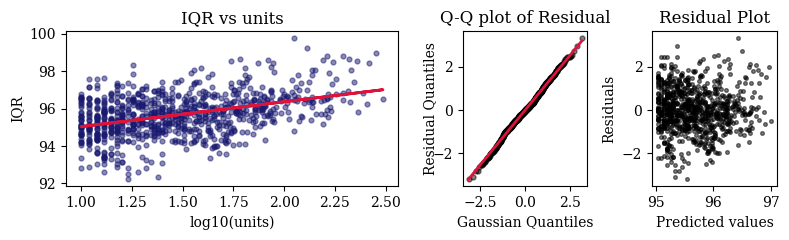

In [124]:
fsize1 = 12
fsize2 = 10
fsize3 = 8
fsize4 = 6

fig, axs = plt.subplots(1, 3, figsize=(8,2.5), gridspec_kw={'width_ratios': [4,1.5,1.5]})
ax = axs[0]

ax.scatter(np.log10(units_list), elec_stats_list, s=12, c='midnightblue', alpha=0.5)

# linear regression
x = np.array(np.log10(units_list))
y = np.array(elec_stats_list)
m, b = np.polyfit(x, y, 1)
error = y - (m*x + b)
ax.plot(x, m*x + b, linewidth=2, c = 'crimson')

R2 = np.corrcoef(x, y)[0,1]**2
print(f'R2: {R2:.4f}')

ax.set_xlabel('log10(units)', fontsize=fsize2)
ax.set_ylabel('IQR', fontsize=fsize2)
ax.set_title('IQR vs units', fontsize=fsize1)

ax = axs[1]
res = stats.probplot(error, dist="norm", plot=ax)
ax.get_lines()[1].set_linewidth(2)
ax.get_lines()[1].set_color('crimson')
# marker settngs
ax.get_lines()[0].set_marker('.')
ax.get_lines()[0].set_markersize(7)
# marker color
ax.get_lines()[0].set_color('black')
# alpha
ax.get_lines()[0].set_alpha(0.5)

ax.set_xlabel('Gaussian Quantiles', fontsize=fsize2)
ax.set_ylabel('Residual Quantiles', fontsize=fsize2, labelpad=-3)
ax.set_title('Q-Q plot of Residual', fontsize=fsize1)

import statsmodels.api as sm
import statsmodels.stats.diagnostic as sms

# x와 잔차 계산
x = np.array(x)
error = np.array(error)

# 예측된 값 계산
predicted_y = m * x + b

ax = axs[2]

# 잔차 플롯
ax.scatter(predicted_y, error, s=7, c='black', alpha=0.5)
ax.set_xlabel('Predicted values', fontsize=fsize2)
ax.set_ylabel('Residuals', fontsize=fsize2)
ax.set_title('Residual Plot', fontsize=fsize1)

# 독립 변수 x에 상수항 추가
x_with_const = sm.add_constant(x)

# Breusch-Pagan Test 수행
bp_test = sms.het_breuschpagan(error, x_with_const)

# Breusch-Pagan Test 결과 출력
labels = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
bp_test_result = dict(zip(labels, bp_test))

for key, value in bp_test_result.items():
    print(f'{key}: {value}')

fig.tight_layout()
fig.savefig(Path(figure_path, 'iqr_vs_units.png'), dpi=600)

___

In [10]:
def split_routine(dt_hour):
    conditions = [
        (dt_hour >= 0) & (dt_hour  <= 5),
        (dt_hour >= 6) & (dt_hour <= 9),
        (dt_hour >= 10) & (dt_hour <= 13),
        (dt_hour >= 14) & (dt_hour <= 17),
        (dt_hour >= 18)
    ]
    choices = [0, 1, 2, 3, 4]
    return np.select(conditions, choices, default=-1)

TIMECYC_LAMBDA_T = {
    'dow': (lambda dt: dt.dayofweek, 7),
    'dom': (lambda dt: dt.day, 31),
    'doy': (lambda dt: dt.dayofyear, 365),
    'woy': (lambda dt: dt.isocalendar().week.clip(upper=51), 51),
    'month': (lambda dt: dt.month, 12),
    'h24': (lambda dt: dt.hour+1, 24),
    'routine': (lambda dt: split_routine(dt.hour), 5)
}

TIMEBIN_VARIABLES = ['weekend', 'holiday']

In [11]:
dt_elec = {}

for year2 in [2020, 2021, 2022]:
    dt_elec_pair = train_data[(train_data['year']==year2) & (train_data['is_dummy']==0) ][['datetime', 'elec', 'holiday']].reset_index(drop=True)
    dt_ = dt_elec_pair['datetime'].values
    elec_ = dt_elec_pair['elec'].values
    holiday_ = dt_elec_pair['holiday'].values
    dt_elec[year2] = {'datetime': dt_, 'elec': elec_, 'holiday': holiday_}

In [12]:
val_year = 2021
dt_ = dt_elec[val_year]['datetime']
# as pd datetime
dt_ = pd.to_datetime(dt_)
elec_ = dt_elec[val_year]['elec']
holiday_ = dt_elec[val_year]['holiday']

dow_cats = np.zeros(len(dt_), dtype=int)
dom_cats = np.zeros(len(dt_), dtype=int)
doy_cats = np.zeros(len(dt_), dtype=int)
woy_cats = np.zeros(len(dt_), dtype=int)
month_cats = np.zeros(len(dt_), dtype=int)
h24_cats = np.zeros(len(dt_), dtype=int)
routine_cats = np.zeros(len(dt_), dtype=int)

for key, (func, num_cats) in TIMECYC_LAMBDA_T.items():
    if key == 'dow':
        dow_cats = func(dt_)
    elif key == 'dom':
        dom_cats = func(dt_)
    elif key == 'doy':
        doy_cats = func(dt_)
    elif key == 'woy':
        woy_cats = func(dt_)
    elif key == 'month':
        month_cats = func(dt_)
    elif key == 'h24':
        h24_cats = func(dt_)
    elif key == 'routine':
        routine_cats = func(dt_)

In [23]:
weekend_ = (dow_cats >= 5).astype(int)

/tmp/ipykernel_2629099/3456041799.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(
/tmp/ipykernel_2629099/3456041799.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(
/tmp/ipykernel_2629099/3456041799.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(
/tmp/ipykernel_2629099/3456041799.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(


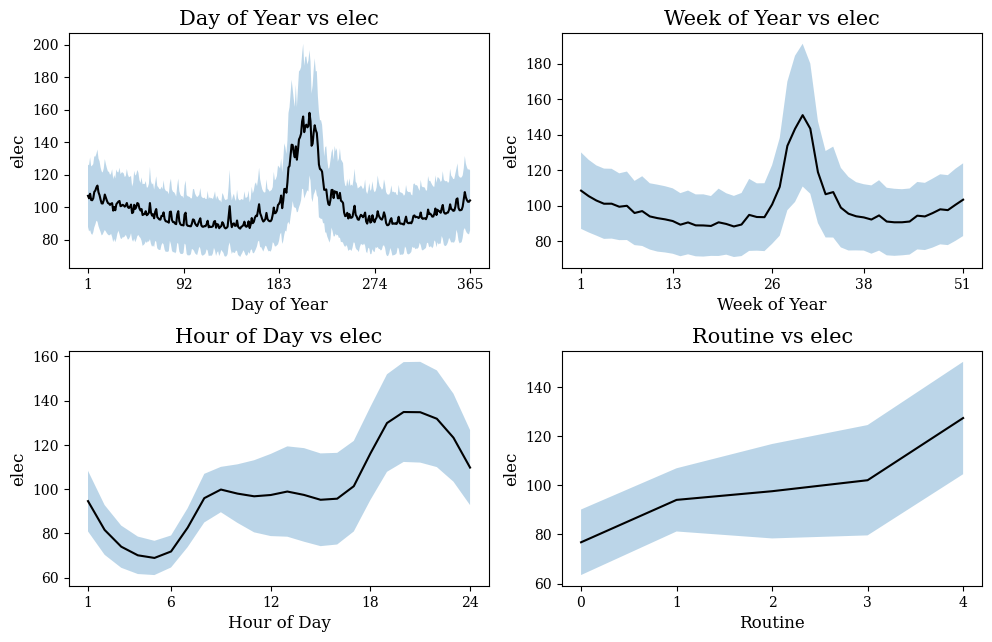

In [39]:
fsize1 = 15
fsize2 = 12
fsize3 = 10
fsize4 = 8

def category_fill_between(elec_, category, category_name, ax):
    category_values = np.unique(category)
    category_values.sort()
    mean_list = []
    std_list = []
    for i, val in enumerate(category_values):
        elec_val = elec_[category == val]
        elec_val_mean = np.mean(elec_val)
        elec_val_std = np.std(elec_val)
        mean_list.append(elec_val_mean)
        std_list.append(elec_val_std)
    ax.plot(category_values, mean_list, color='black')
    ax.fill_between(category_values, np.array(mean_list) - np.array(std_list), 
                    np.array(mean_list) + np.array(std_list), alpha=0.3)
    ax.set_xlabel(category_name, fontsize=fsize2)
    ax.set_ylabel('elec', fontsize=fsize2)
    ax.set_title(f'{category_name} vs elec', fontsize=fsize1)
    ax.tick_params(axis='both', which='major', labelsize=fsize3)

    # xtick as category values, but only 5 ticks
    ax.set_xticks(
        np.linspace(category_values[0], category_values[-1], 5, dtype=int)
    )

    ax.set_xticklabels(
        np.linspace(category_values[0], category_values[-1], 5, dtype=int),
        fontsize=fsize3
    )
    # ytickfontsize, ytick as integer
    ax.set_yticklabels(
        [f'{int(y)}' for y in ax.get_yticks()],
        fontsize=fsize3
    )


fig, axs = plt.subplots(2, 2, figsize=(10, 6.5))

category_fill_between(elec_, doy_cats, 'Day of Year', axs[0, 0])
category_fill_between(elec_, woy_cats, 'Week of Year', axs[0, 1])
category_fill_between(elec_, h24_cats, 'Hour of Day', axs[1, 0])
category_fill_between(elec_, routine_cats, 'Routine', axs[1, 1])

fig.tight_layout(pad=1.0)

fig.savefig(Path(figure_path, 'time_category_boxplot.png'), dpi=600)